In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from datetime import datetime
import tf2onnx
import onnx
import onnxruntime as ort
import os
import boto3

2024-03-09 11:05:40.576160: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-09 11:05:41.201853: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-09 11:05:41.203273: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-09 11:05:43.041201: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
(X_train,y_train),(X_test,y_test) = keras.datasets.mnist.load_data()

X_train = X_train/255
X_test = X_test/255

# Training

Let's train a an alternative, a convoluted neural network:

In [3]:
model = Sequential()

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=64, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 64)                346176    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                        

In [4]:
history = model.fit(X_train,y_train,epochs=3)

Epoch 1/3
1875/1875 [==============================] - 73s 38ms/step - loss: 0.2465 - accuracy: 0.9259
Epoch 2/3
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1038 - accuracy: 0.9684
Epoch 3/3
1875/1875 [==============================] - 239s 128ms/step - loss: 0.0772 - accuracy: 0.9756


In [5]:
y_prob = model.predict(X_test)
y_pred = y_prob.argmax(axis=1)
accuracy_score(y_test,y_pred)

313/313 [==============================] - 1s 1ms/step


0.9809

# Demo

Let's try out the nn with a small demo, given the following:

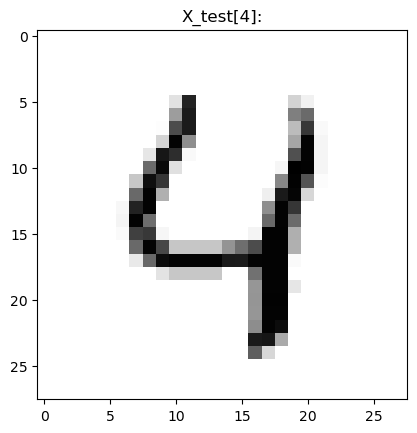

In [6]:
plt.imshow(X_test[4], cmap="Greys")
plt.title('X_test[4]:')
plt.show()

the model predicts it is:

In [7]:
prediction = model.predict(X_test[4].reshape(1,28,28)).argmax(axis=1)[0]
print('prediction: ', prediction)

1/1 [==============================] - 0s 210ms/step
prediction:  4


# Model Save

In [8]:
input_signature = [tf.TensorSpec([1, 28, 28], tf.double, name='x')]
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature, opset=12)
onnx.save(onnx_model, "model2.onnx")

2024-03-09 11:12:49.104964: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-03-09 11:12:49.108924: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2024-03-09 11:12:49.182228: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-03-09 11:12:49.182398: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session


# Demo using onnx file

In [9]:
model_onnx = onnx.load('model2.onnx')
output = [node.name for node in model_onnx.graph.output]
print(output)

sess = ort.InferenceSession("model2.onnx")
results_ort = sess.run(['dense_1'], {'x': X_test[4].reshape(1,28,28)})
prediction = results_ort[0].argmax(axis=1)[0]
print('prediction: ', prediction)

['dense_1']
prediction:  4


# Store onnx on bucket

In [10]:
registeredmodel_name = "mnist"
version_name = "v2.nb"+datetime.now().strftime("%Y%m%d%H%M%S")
print(f"Will be using: {registeredmodel_name}:{version_name} in the remainder of this task")

s3 = boto3.resource(
    service_name='s3',
    region_name='default',
    aws_access_key_id=os.environ['accesskey'],
    aws_secret_access_key=os.environ['secretkey'],
    use_ssl=False,
    endpoint_url='http://minio-service.kubeflow.svc.cluster.local:9000',
    verify=False
)

bucket_name = 'mybucket'
odh_secret_name = f'aws-connection-{bucket_name}'
in_bucket_path = version_name
in_bucket_target = f'{in_bucket_path}/mnist.onnx'
full_bucket_target = f's3://{bucket_name}/{in_bucket_target}'

my_bucket = s3.Bucket(bucket_name)
my_bucket.upload_file("model2.onnx", in_bucket_target)

print("ls:")
for obj in my_bucket.objects.filter():
    print(obj.key)

Will be using: mnist:v2.nb20240309111249 in the remainder of this task
ls:
README.md
v1.nb20240309105815/mnist.onnx
v2.nb20240309111249/mnist.onnx


# Register model on Model Registry

In [11]:
from model_registry import ModelRegistry

registry = ModelRegistry(server_address="model-registry-service.kubeflow.svc.cluster.local", port=9090, author="mmortari")

rm = registry.register_model(registeredmodel_name,
                                full_bucket_target,
                                model_format_name="onnx",
                                model_format_version="1",
                                storage_key=odh_secret_name,
                                storage_path=in_bucket_path,
                                version=version_name,
                                description="demo20231121 e2e MNIST",
                                )
print("RegisteredModel:")
print(registry.get_registered_model(registeredmodel_name))
print("ModelVersion:")
print(registry.get_model_version(registeredmodel_name, version_name))
print("ModelArtifact:")
print(registry.get_model_artifact(registeredmodel_name, version_name))

RegisteredModel:
RegisteredModel(id='1', description='', external_id='', create_time_since_epoch=1709982167800, last_update_time_since_epoch=1709982167800, state=<ContextState.LIVE: 'LIVE'>, name='mnist')
ModelVersion:
ModelVersion(name='v2.nb20240309111249', id='3', description='demo20231121 e2e MNIST', external_id='', create_time_since_epoch=1709982772958, last_update_time_since_epoch=1709982772958, state=<ContextState.LIVE: 'LIVE'>, model_name='mnist', version='v2.nb20240309111249', author='mmortari', metadata={}, artifacts=NOTHING, _registered_model_id=NOTHING)
ModelArtifact:
ModelArtifact(id='2', description='', external_id='', create_time_since_epoch=1709982773133, last_update_time_since_epoch=1709982773133, name='mnist', uri='s3://mybucket/v2.nb20240309111249/mnist.onnx', state=<ArtifactState.UNKNOWN: 0>, model_format_name='onnx', model_format_version='1', storage_key='aws-connection-mybucket', storage_path='v2.nb20240309111249', service_account_name='', _model_version_id=NOTHIN